In [50]:
import os
import pandas as pd
import numpy as np

import math

import sklearn

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelBinarizer

from sklearn.manifold import TSNE

In [5]:
np.random.seed(42)

diabetic = pd.read_csv('training/diabetes/diabetic_data_balanced.csv')

# Anonymise
diabetic = diabetic.groupby('patient_nbr', group_keys=False) \
                    .apply(lambda df: df.sample(1))


# Train test split
X, y = diabetic.drop('readmitted', axis=1), diabetic['readmitted']

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(X, y):
     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [6]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
# PREPROCESSING PIPELINE
diabetic_num_to_cat_features = ['admission_type_id', 'discharge_disposition_id','admission_source_id']

diabetic_cat_to_num_features = ['max_glu_serum', 'A1Cresult']

diabetic_num_features = ['time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

diabetic_drugs = []

diabetic_cat_features = ['race', 'gender', 'change', 'diabetesMed']
diabetic_diag_features = ['diag_1', 'diag_2', 'diag_3']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(diabetic_num_features)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

age_pipeline = Pipeline([
    ('selector', DataFrameSelector(['age'])),
    ('ordinal_encoder', OrdinalEncoder(categories=[['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']])),
    ('std_scaler', StandardScaler()),
])


full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ('age_pipeline', age_pipeline),
])

In [10]:
X_prepared = full_pipeline.fit_transform(X)

In [11]:
X_prepared

array([[-0.56448981, -0.866438  , -0.28758356, ...,  0.59783576,
        -0.88754326, -0.53244174],
       [-0.88254833,  0.11159811, -0.28758356, ..., -0.43146794,
        -1.8733715 , -0.53244174],
       [ 0.07162723,  0.11159811, -0.8567325 , ..., -0.43146794,
        -1.8733715 , -1.72947504],
       ...,
       [-1.20060685,  0.00292743,  1.98901219, ..., -0.43146794,
         0.09828499,  1.26310822],
       [-0.88254833,  0.32893947, -0.8567325 , ..., -0.43146794,
        -0.88754326, -1.13095839],
       [ 0.07162723, -0.16007859, -0.28758356, ...,  2.65644314,
         0.59119911, -0.53244174]])

In [15]:
X_df = pd.DataFrame(X_prepared, columns=diabetic_num_features + ['age'])

In [18]:
X_df

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,age
0,-0.564490,-0.866438,-0.287584,-0.166663,-0.18037,-0.163485,0.597836,-0.887543,-0.532442
1,-0.882548,0.111598,-0.287584,-0.537593,-0.18037,-0.163485,-0.431468,-1.873372,-0.532442
2,0.071627,0.111598,-0.856733,-1.279453,-0.18037,-0.163485,-0.431468,-1.873372,-1.729475
3,0.389686,-0.214414,0.281565,-0.290307,-0.18037,-0.163485,0.597836,-2.366286,-0.532442
4,-1.200607,0.002927,1.989012,-0.413950,-0.18037,-0.163485,0.597836,0.098285,-1.130958
...,...,...,...,...,...,...,...,...,...
7939,0.707744,0.002927,-0.287584,0.822483,-0.18037,-0.163485,-0.431468,1.084113,1.263108
7940,-0.882548,0.763622,1.419863,-0.537593,-0.18037,-0.163485,-0.431468,0.591199,0.066075
7941,-1.200607,0.002927,1.989012,-0.290307,-0.18037,-0.163485,-0.431468,0.098285,1.263108
7942,-0.882548,0.328939,-0.856733,-0.413950,-0.18037,-0.163485,-0.431468,-0.887543,-1.130958


# PCA

In [19]:
pca = sklearn.decomposition.PCA()
pca_result = pca.fit_transform(X_prepared)

# how the results are returned
print("μ:", pca.mean_)
k,i = 2,10
print(f"δ[k={k}]:", pca.components_[k])
print(f"λ[k={k},i={i}]:", pca_result[i,k])

μ: [ 4.47219748e-17  1.00177224e-16  2.32554269e-17  1.00177224e-16
 -1.43110319e-17  0.00000000e+00  0.00000000e+00  1.93198931e-16
 -2.28976511e-16]
δ[k=2]: [ 0.02163186  0.03480784  0.38756511  0.26851249  0.12350918  0.15433341
  0.04305728 -0.43275691 -0.74014121]
λ[k=2,i=10]: -0.5760937150865132


In [20]:
pca_result.shape

(7944, 9)

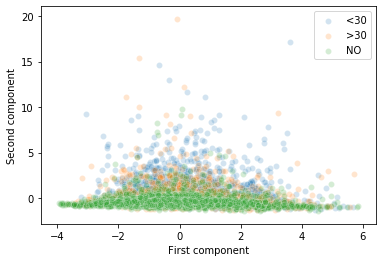

In [47]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cp = sns.color_palette()
%matplotlib inline

p1,p2 = pca_result[:,0], pca_result[:,1]

colors = {'<30': cp[0], '>30': cp[1], 'NO': cp[2]}

for lvl in ['<30', '>30', 'NO']:
    i = (y == lvl)
    sns.scatterplot(p1[i], p2[i], alpha=0.2, label=lvl, palette=colors)
    
plt.xlabel('First component')
plt.ylabel('Second component')
plt.savefig('pca.png', bbox_inches='tight', dpi=600)
plt.show()

# t-SNE

In [52]:
tsne = TSNE(n_components=2, verbose=1)
tsne_result = tsne.fit_transform(X_prepared)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7944 samples in 0.068s...
[t-SNE] Computed neighbors for 7944 samples in 0.947s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7944
[t-SNE] Computed conditional probabilities for sample 2000 / 7944
[t-SNE] Computed conditional probabilities for sample 3000 / 7944
[t-SNE] Computed conditional probabilities for sample 4000 / 7944
[t-SNE] Computed conditional probabilities for sample 5000 / 7944
[t-SNE] Computed conditional probabilities for sample 6000 / 7944
[t-SNE] Computed conditional probabilities for sample 7000 / 7944
[t-SNE] Computed conditional probabilities for sample 7944 / 7944
[t-SNE] Mean sigma: 0.528898
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.735954
[t-SNE] KL divergence after 1000 iterations: 1.854899


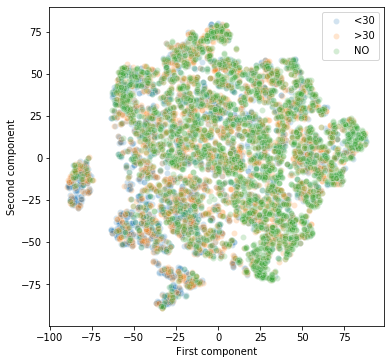

In [55]:
p1,p2 = tsne_result[:,0], tsne_result[:,1]

fig, ax = plt.subplots(figsize=(6,6))
for lvl in ['<30', '>30', 'NO']:
    i = (y == lvl)
    sns.scatterplot(p1[i], p2[i], alpha=0.2, label=lvl, palette=colors)
    
plt.xlabel('First component')
plt.ylabel('Second component')
ax.set_aspect('equal')
plt.savefig('tsne.png', bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
tsnes = [sklearn.manifold.TSNE(n_components=2, perplexity=10.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=30.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=50.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=75.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=100.0, verbose=1)]
tsne_results = [tsne.fit_transform(X_prepared) for tsne in tsnes]

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7944 samples in 0.053s...
[t-SNE] Computed neighbors for 7944 samples in 0.673s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7944
[t-SNE] Computed conditional probabilities for sample 2000 / 7944
[t-SNE] Computed conditional probabilities for sample 3000 / 7944
[t-SNE] Computed conditional probabilities for sample 4000 / 7944
[t-SNE] Computed conditional probabilities for sample 5000 / 7944
[t-SNE] Computed conditional probabilities for sample 6000 / 7944
[t-SNE] Computed conditional probabilities for sample 7000 / 7944
[t-SNE] Computed conditional probabilities for sample 7944 / 7944
[t-SNE] Mean sigma: 0.412008
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.667526
[t-SNE] KL divergence after 1000 iterations: 1.780116
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7944 samples in 0.085s...
[t-SNE] Computed neighbors for 7944 samples in 1.028s...
[t-SNE] Computed conditional 

In [ ]:
fig = plt.figure(figsize=(25, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.4)
index = 0
plot_index = 1
perplexities = [5, 10, 15, 30, 50]

for i in range(5):
    ax = fig.add_subplot(1, 5, plot_index)
    p1,p2 = tsne_results[index][:,0], tsne_results[index][:,1]

    for lvl in ['<30', '>30', 'NO']:
        i = (y == lvl)
        sns.scatterplot(p1[i], p2[i], alpha=0.2, label=lvl, legend=None)
        ax.set_aspect('equal')
        ax.set_title(perplexities[index])

    index += 1
    plot_index +=1

plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))       
plt.show()